<a href="https://colab.research.google.com/github/von-ai/youtube-title-comment-similarity/blob/main/youtube-title-comment-similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inisialisasi**

In [ ]:
!pip install google-api-python-client pandas tqdm scikit-learn

In [ ]:
import pandas as pd
from googleapiclient.discovery import build
from tqdm import tqdm
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# **Ambil Dataset from Youtube using youtube API v3**

In [ ]:
API_KEY = "add your API using youtube API v3 :>"
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [ ]:
videos = [
    {"id": "zyqpFFfMO_g", "title": "Curhatan Seorang Dokter Frustasi"},
    {"id": "_YvSArB1GhQ", "title": "1.5 JUTAAN! Unboxing Redmi 15C Indonesia"},
    {"id": "anZrat7IIM8", "title": "RRQ ga lolos Playoff 😞👆"},
    {"id": "xnjmryw20vc", "title": "PABRIK GARMEN ANGKER SOLO!| #NERROR CERITA HORROR"},
    {"id": "PU24YOxCbOM", "title": "GENDUT HARUS DIBULLY?? 158 KG!!!"},
]

In [ ]:
def get_comments(video_id, max_results=300):
    comments = []
    next_page_token = None

    while len(comments) < max_results:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=min(100, max_results - len(comments)),
            pageToken=next_page_token,
            textFormat='plainText'
        ).execute()

        for item in response.get('items', []):
            snippet = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'comment_id': item['id'],
                'author': snippet.get('authorDisplayName'),
                'text': snippet.get('textDisplay'),
                'publishedAt': snippet.get('publishedAt'),
            })

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return pd.DataFrame(comments)

In [ ]:
def normalize(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_similarity(title, comments):
    title_norm = normalize(title)
    comments['text_norm'] = comments['text'].astype(str).apply(normalize)

    texts = [title_norm] + comments['text_norm'].tolist()
    vectorizer = TfidfVectorizer().fit(texts)
    vectors = vectorizer.transform(texts)

    sims = cosine_similarity(vectors[0:1], vectors[1:]).flatten()
    comments['similarity'] = sims

    threshold = 0.78
    comments['pred'] = (comments['similarity'] >= threshold).astype(int)
    return comments

In [ ]:
all_comments = []

for v in videos:
    print(f"Mengambil komentar dari: {v['title']}")
    df = get_comments(v["id"])
    if not df.empty:
        df = compute_similarity(v["title"], df)
        df["video_id"] = v["id"]
        df["video_title"] = v["title"]
        all_comments.append(df)

data = pd.concat(all_comments, ignore_index=True)
data.to_csv("youtube_titlelike_dataset.csv", index=False)
data.head(10)

Mengambil komentar dari: Curhatan Seorang Dokter Frustasi
Mengambil komentar dari: 1.5 JUTAAN! Unboxing Redmi 15C Indonesia
Mengambil komentar dari: RRQ ga lolos Playoff 😞👆
Mengambil komentar dari: PABRIK GARMEN ANGKER SOLO!| #NERROR CERITA HORROR
Mengambil komentar dari: GENDUT HARUS DIBULLY?? 158 KG!!!


,comment_id,author,text,publishedAt,text_norm,similarity,pred,video_id,video_title
0,UgzXYD2FkPdGn5yceJp4AaABAg,@cucuwahidin2566,TAG teh yura yunita biar ka done ketemu dokter...,2025-11-13T06:42:48Z,tag teh yura yunita biar ka done ketemu dokter...,0.060051,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
1,UgykYuM5MfU3NmngT5h4AaABAg,@MrRey.,gpp begadang asal tim nya jago 😂,2025-11-13T06:33:17Z,gpp begadang asal tim nya jago,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
2,UgyiCxlEfOSUZw76b5d4AaABAg,@_Min_7,Dinginya oiii🥶🤣,2025-11-13T05:14:20Z,dinginya oiii,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
3,UgywmHvXgS6PjyprS_F4AaABAg,@cindyyolandita31,“gen z stress”\niya mas radit emang😭😭😭,2025-11-13T04:17:14Z,gen z stress iya mas radit emang,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
4,UgyvLw4px7vAFxmPTDJ4AaABAg,@carijulietsaja,konten sangat kreatif dan pembawaan nya sangat...,2025-11-13T03:50:30Z,konten sangat kreatif dan pembawaan nya sangat...,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
5,UgzBh6YgtCfgqtDN2ax4AaABAg,@wetcigarettes,sumpah lucu banget bagian diketawain chat gpt ...,2025-11-13T03:34:29Z,sumpah lucu banget bagian diketawain chat gpt ...,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
6,Ugx7ZgiBXAuhPJ9gtlp4AaABAg,@khoirulfikri2455,Doktr klo coba mancing jg pasti ketagihan,2025-11-13T03:05:31Z,doktr klo coba mancing jg pasti ketagihan,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
7,UgzwwVH_R1DEmdhLUnt4AaABAg,@hafizabdillah8312,11:25 kocaakkk bangeett ahahahahahhahaha,2025-11-13T02:40:41Z,1125 kocaakkk bangeett ahahahahahhahaha,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
8,Ugzinkeyz5iKQd2cl3N4AaABAg,@pratiwipardiyanto7440,Gara-gara bang Radit aku coba chat gpt ternyat...,2025-11-13T02:09:30Z,garagara bang radit aku coba chat gpt ternyata...,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi
9,UgzRfhQxmnTk1kHOok54AaABAg,@muhammadkhipe6332,HAHA DI KETAWAIN CHAT GPT🤣,2025-11-13T02:05:42Z,haha di ketawain chat gpt,0.000000,0,zyqpFFfMO_g,Curhatan Seorang Dokter Frustasi


In [ ]:
from google.colab import files
files.download("youtube_titlelike_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Inti**

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv("youtube_titlelike_dataset.csv")

In [ ]:
print("Jumlah data:", len(df))
print(df.head())

Jumlah data: 1500
                   comment_id             author  \
0  UgzXYD2FkPdGn5yceJp4AaABAg   @cucuwahidin2566   
1  UgykYuM5MfU3NmngT5h4AaABAg            @MrRey.   
2  UgyiCxlEfOSUZw76b5d4AaABAg            @_Min_7   
3  UgywmHvXgS6PjyprS_F4AaABAg  @cindyyolandita31   
4  UgyvLw4px7vAFxmPTDJ4AaABAg    @carijulietsaja   

                                                text           publishedAt  \
0  TAG teh yura yunita biar ka done ketemu dokter...  2025-11-13T06:42:48Z   
1                   gpp begadang asal tim nya jago 😂  2025-11-13T06:33:17Z   
2                                    Dinginya oiii🥶🤣  2025-11-13T05:14:20Z   
3             “gen z stress”\niya mas radit emang😭😭😭  2025-11-13T04:17:14Z   
4  konten sangat kreatif dan pembawaan nya sangat...  2025-11-13T03:50:30Z   

                                           text_norm  similarity  pred  \
0  tag teh yura yunita biar ka done ketemu dokter...    0.060051     0   
1                     gpp begadang asal tim nya jago

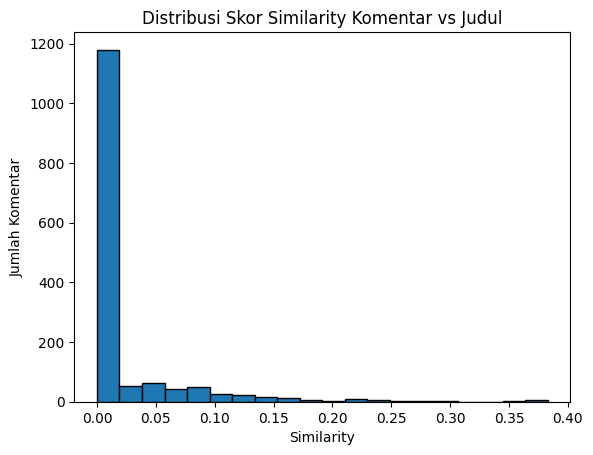

In [ ]:
plt.hist(df['similarity'], bins=20, edgecolor='black')
plt.title("Distribusi Skor Similarity Komentar vs Judul")
plt.xlabel("Similarity")
plt.ylabel("Jumlah Komentar")
plt.show()

In [ ]:
def count_upper_ratio(text):
    if not isinstance(text, str) or len(text) == 0:
        return 0
    upper = sum(1 for c in text if c.isupper())
    return upper / len(text)

def count_emojis(text):
    if not isinstance(text, str):
        return 0
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return len(emoji_pattern.findall(text))

df['upper_ratio'] = df['text'].apply(count_upper_ratio)
df['emoji_count'] = df['text'].apply(count_emojis)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

# Rule-based detection
def rule_based_detection(row):
    if row['similarity'] > 0.8:
        return 1
    if row['upper_ratio'] > 0.6 and len(row['text']) < 40:
        return 1
    if row['emoji_count'] > 2 and row['similarity'] > 0.6:
        return 1
    return 0

df['rule_pred'] = df.apply(rule_based_detection, axis=1)

print(df[['text', 'similarity', 'upper_ratio', 'emoji_count', 'rule_pred']].head(10))

                                                text  similarity  upper_ratio  \
0  TAG teh yura yunita biar ka done ketemu dokter...    0.060051     0.057692   
1                   gpp begadang asal tim nya jago 😂    0.000000     0.000000   
2                                    Dinginya oiii🥶🤣    0.000000     0.066667   
3             “gen z stress”\niya mas radit emang😭😭😭    0.000000     0.000000   
4  konten sangat kreatif dan pembawaan nya sangat...    0.000000     0.000000   
5  sumpah lucu banget bagian diketawain chat gpt ...    0.000000     0.000000   
6          Doktr klo coba mancing jg pasti ketagihan    0.000000     0.024390   
7           11:25 kocaakkk bangeett ahahahahahhahaha    0.000000     0.000000   
8  Gara-gara bang Radit aku coba chat gpt ternyat...    0.000000     0.029126   
9                         HAHA DI KETAWAIN CHAT GPT🤣    0.000000     0.807692   

   emoji_count  rule_pred  
0            0          0  
1            1          0  
2            0          

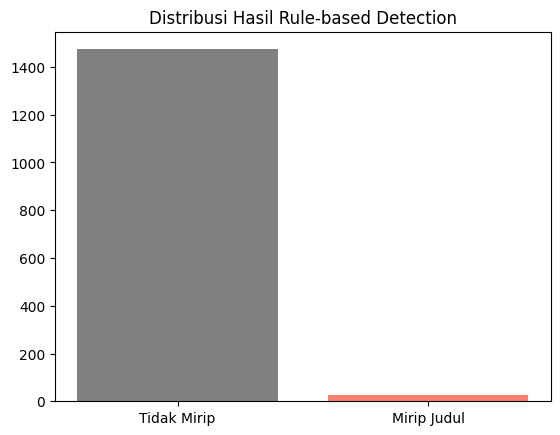

In [ ]:
labels, counts = np.unique(df['rule_pred'], return_counts=True)
plt.bar(['Tidak Mirip', 'Mirip Judul'], counts, color=['gray', 'salmon'])
plt.title("Distribusi Hasil Rule-based Detection")
plt.show()

In [ ]:
df.to_csv("youtube_rule_based_analysis.csv", index=False)